In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
guass1 = np.random.normal(0,1,(100,2))
guass2 = np.random.normal(1,1,(100,2))
data = np.vstack([guass1, guass2])
labels = np.vstack([np.ones(len(guass1)).reshape(-1,1), np.zeros(len(guass2)).reshape(-1,1)]).reshape(-1)

In [3]:
data.shape, labels.shape

((200, 2), (200,))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,labels)

In [5]:
# from xgboost import XGBClassifier
# bdt = XGBClassifier()
# bdt.fit(X_train, y_train)

In [6]:
import lightgbm as lgb
bdt = lgb.LGBMClassifier()
bdt.fit(X_train, y_train)

/Users/aishik-mac/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [7]:
from sklearn.metrics import roc_auc_score
y_pred_bdt = bdt.predict_proba(X_test)[:,1]
y_pred_bdt = y_pred_bdt.ravel()
y_pred_train_bdt = bdt.predict_proba(X_train)[:,1].ravel()
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_bdt)
print (auc_test)
print (roc_auc_score(y_true=y_train, y_score=y_pred_train_bdt,))

0.8624787775891342
0.9655573447843979


In [8]:
weights_test = np.ones(len(y_test))
#weights_test = np.random.normal(1,0.7,len(y_test))

In [9]:
weights_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# PI new

In [10]:
#uncomment if installed from pip
#from permutationimportancephysics.PermutationImportance import PermulationImportance

#only for Dev
from PermutationImportance import PermulationImportance


In [11]:
#PermulationImportance(model=bdt, X=X_test,y=y_test,n_iterations=5000,usePredict_poba=True ).dislayResults()
pi = PermulationImportance(model=bdt, X=X_test,y=y_test,weights=weights_test,n_iterations=5000,usePredict_poba=True,
                          scoreFunction="AUC")
                           #scoreFunction="amsasimov")
pi.dislayResults()

[['0.19229269949066194' '0.0009351410116913151' '0.06612445507325775'
  'feature1']
 ['0.15974685908319114' '0.0007260612295966528' '0.0513402819004436'
  'feature0']]


In [12]:
#PermulationImportance(model=bdt, X=X_test,y=y_test,n_iterations=5000,usePredict_poba=True ).dislayResults()
pi = PermulationImportance(model=bdt, X=X_test,y=y_test,weights=weights_test,n_iterations=5000,usePredict_poba=True,
                          #scoreFunction="AUC")
                           scoreFunction="amsasimov")
pi.dislayResults()

[['1.5795173429463363' '0.007885253547646028' '0.5575716254915787'
  'feature1']
 ['1.28143093845322' '0.007094569798211194' '0.5016618413916412'
  'feature0']]


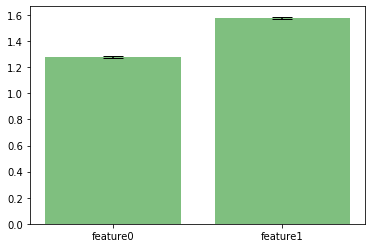

In [13]:
plt = pi.plotBars()
plt.show()

In [14]:
# my errors are more correct but underestimates, ELI5 overestimates the errors, I re-ran to see 
# best to report both

# Permutation Importace (ELI5)

In [15]:
def auc_scorer(estimator, X, y):
    Y_pred = estimator.predict_proba(X)[:,1]
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_score=Y_pred, y_true=y, sample_weight=np.ones(len(Y_pred)))

In [16]:
def significance_score(estimator, X,y):
        def amsasimov(s,b):
            from math import sqrt,log
            if b<=0 or s<=0:
                return 0
            try:
                return sqrt(2*((s+b)*log(1+float(s)/b)-s))
            except ValueError:
                print (1+float(s)/b)
                print (2*((s+b)*log(1+float(s)/b)-s))
            #return s/sqrt(s+b)
        Y_pred = estimator.predict_proba(X)[:,1]
        first, last, n_cuts = 0.2, 1., 30
        #@TODO: Histogram loop with numba or parallelise
        int_sig = [weights_test[(y_test ==1) & (Y_pred > th_cut)].sum() for th_cut in np.linspace(first,last,num=n_cuts)]
        int_bkg = [weights_test[(y_test ==0) & (Y_pred > th_cut)].sum() for th_cut in np.linspace(first,last,num=n_cuts)]
        vZ = [amsasimov(s=sumsig,b=sumbkg) for (sumsig,sumbkg) in zip(int_sig,int_bkg)]
        bestiZ = max(vZ)
        return bestiZ

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

In [18]:
permAUC = PermutationImportance(bdt, n_iter=50, scoring=auc_scorer ).fit(X_test,y_test)
permZ = PermutationImportance(bdt, n_iter=5000, scoring=significance_score ).fit(X_test,y_test)

In [19]:
eli5.show_weights(permAUC, top=None)

Weight,Feature
0.1928 ± 0.1317,x1
0.1541 ± 0.0938,x0


In [20]:
eli5.show_weights(permZ, top=None)

Weight,Feature
1.5949 ± 1.1083,x1
1.2757 ± 1.0065,x0


In [24]:
from platform import python_version
print(python_version())

3.6.6


In [23]:
!python -V  # for python version (2/3)
!python -m pip --version

Python 3.6.6
pip 19.2.1 from /Users/aishik-mac/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pip (python 3.6)
